# Cross valadation in MOp dataset 

In [1]:
import pandas as pd
import numpy  as np
import anndata
import scanpy as sc
from emerge import run_emerge
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

Read spatial dataset and scRNA-seq dataset. Datasets can be downloaded from **Zenodo**:  
[10.5281/zenodo.17214560](https://doi.org/10.5281/zenodo.17214560).

In [2]:
#exp
fish_exp_raw = pd.read_csv('data/spatial/m2s2s300.csv',header=0,index_col=0,sep=',')
#type
fish_type = pd.read_csv('data/spatial/m2s300_label.csv',header=0,index_col=0,sep=',')
fish_type.set_index('cell_ID', inplace=True)
#loc
fish_loc = pd.read_csv('data/spatial/m2s300_loc.csv',header=0,index_col=0,sep=',')

In [3]:
scrna_sc_raw = pd.read_csv('data/scrna/nucsmart/exon.counts.csv',header=0,index_col=0,sep=',')
qcell = pd.read_csv('data/scrna/nucsmart/QC.csv')
scrna_sc_raw = scrna_sc_raw.loc[:,qcell['x']]
scrna_sc_raw = scrna_sc_raw.T
#type
scrna_type_raw = pd.read_csv('data/scrna/nucsmart/cluster.membership.csv',header=0,index_col=0,sep=',')
scrna_type_raw = scrna_type_raw.loc[scrna_sc_raw.index,:]
scrna_type_raw.insert(loc=len(scrna_type_raw.columns), column='Annotation', value=None)
scrna_type_raw.insert(loc=len(scrna_type_raw.columns), column='Annotation2', value=None)
scrna_anno = pd.read_csv('data/scrna/nucsmart/cluster.annotation.csv',header=0,index_col=0,sep=',')
for i in np.unique(scrna_type_raw['x'].values):
    scrna_type_raw.loc[scrna_type_raw['x'] == i, 'Annotation'] = scrna_anno.loc[scrna_anno.index==i,'subclass_label'].values[0]

In [4]:
layeruse = 'Annotation'
common_gene = list(set(scrna_sc_raw.columns) & set(fish_exp_raw.columns))
common_gene = sorted(common_gene)
nums = pd.read_csv('data/spatial/merfish253.txt',header=None,index_col=None,sep=',')
nums = nums.values[0:len(common_gene)]

Emerge-cell

In [6]:
relist_cell = list()
for ss in range(0, 5):   
    print(ss)
    train_index = np.where(nums != ss)[0]        
    train_gene = np.array(common_gene)[train_index]   
    test_index = np.where(nums == ss)[0]        
    test_gene = np.array(common_gene)[test_index]   
    cc = run_emerge(fish_exp_raw = fish_exp_raw,
        fish_loc=fish_loc,           
        scrna_sc_raw = scrna_sc_raw,       
        scrna_type_raw=scrna_type_raw,       
        x_col = "X", y_col = "Y",
        layeruse= "Annotation",
        train_genes=train_gene,
        test_genes=test_gene,
        cell_or_cluster = "cell",     # "cell" "cluster"
        env_backend= "standard",     # "standard"=envpca "big"=envpcabignome for big data  
    ) 
    relist_cell.append(cc)

0
cross-validation
Astro
Endo
L2/3 IT
L5 ET
L5 IT
L5/6 NP
L6 CT
L6 IT
L6b
Lamp5
Micro
OPC
Oligo
Pvalb
Sncg
Sst
Vip
530
1
cross-validation
Astro
Endo
L2/3 IT
L5 ET
L5 IT
L5/6 NP
L6 CT
L6 IT
L6b
Lamp5
Micro
OPC
Oligo
Pvalb
Sncg
Sst
Vip
683
2
cross-validation
Astro
Endo
L2/3 IT
L5 ET
L5 IT
L5/6 NP
L6 CT
L6 IT
L6b
Lamp5
Micro
OPC
Oligo
Pvalb
Sncg
Sst
Vip
810
3
cross-validation
Astro
Endo
L2/3 IT
L5 ET
L5 IT
L5/6 NP
L6 CT
L6 IT
L6b
Lamp5
Micro
OPC
Oligo
Pvalb
Sncg
Sst
Vip
474
4
cross-validation
Astro
Endo
L2/3 IT
L5 ET
L5 IT
L5/6 NP
L6 CT
L6 IT
L6b
Lamp5
Micro
OPC
Oligo
Pvalb
Sncg
Sst
Vip
595


In [7]:
pre_list = [res["pre_sc_test"] for res in relist_cell]
pre_cell = pd.concat(pre_list, axis=1)

In [8]:
fish_raw = anndata.AnnData(fish_exp_raw)
sc.pp.normalize_total(fish_raw)
sc.pp.log1p(fish_raw)

Spatial expression patterns of representative genes, with measured values showed in the first row and predicted values in the second row.

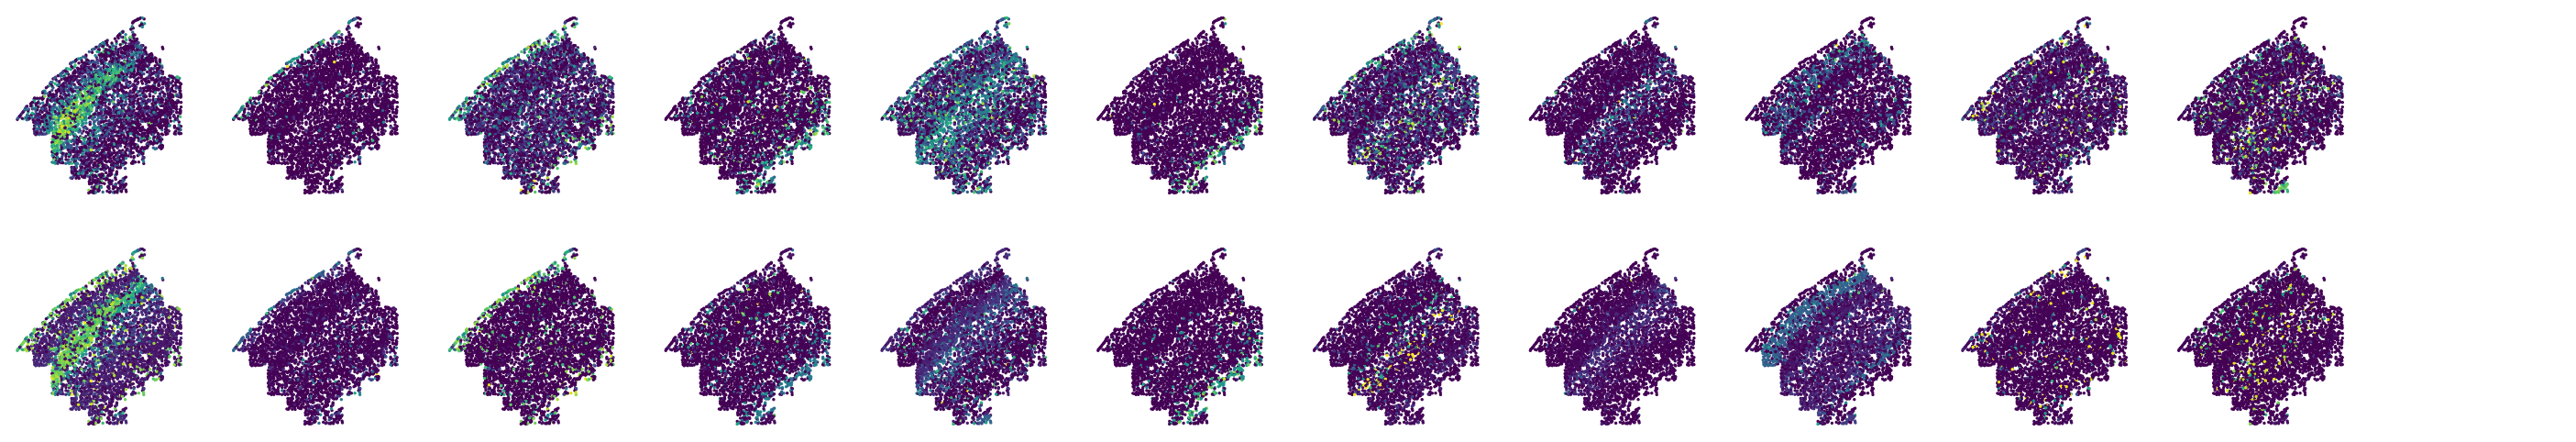

In [13]:
sdgelist = [fish_raw.to_df()[common_gene].T.values,
            pre_cell[common_gene].T.values]
gene_names =fish_raw.to_df()[common_gene].columns
fish_loc_val = fish_loc[['X','Y']].values
genes = ['Rorb','Serpinf1','Aqp4','Prox1','Ptprm','Enpp6','Tshz2','Egln3','Egfem1','Ctss','Slc32a1','Eeln']
plt.figure(figsize=(36,6))
idx=1
for sdge in sdgelist:
    for gene in genes:       
        plt.subplot(len(sdgelist), len(genes), idx)
        plt.scatter(fish_loc_val[:,0], fish_loc_val[:,1], 
                            c=sdge[np.argwhere(gene_names == gene), :].flatten(),s=2, cmap='viridis')
        plt.axis('off')
        plt.gca().invert_yaxis()
        idx += 1
plt.savefig('mea_genel.png', dpi=600)
plt.show()

Emerge-cluster

In [14]:
relist_cluster = list()
for ss in range(0, 5):   
    print(ss)
    train_index = np.where(nums != ss)[0]        
    train_gene = np.array(common_gene)[train_index]   
    test_index = np.where(nums == ss)[0]        
    test_gene = np.array(common_gene)[test_index]   
    cc = run_emerge(
        fish_exp_raw = fish_exp_raw,
        fish_type = fish_type, #important
        fish_loc=fish_loc,            
        scrna_sc_raw = scrna_sc_raw,        
        scrna_type_raw=scrna_type_raw,       
        x_col = "X", y_col = "Y",
        layeruse= "Annotation",
        train_genes=train_gene,
        test_genes=test_gene,
        cell_or_cluster = "cluster",     # "cell" "cluster"
        env_backend= "standard",     # "standard"=envpca "big"=envpcabignome for big data    
    ) 
    relist_cluster.append(cc)
pre_list_c = [res["pre_sc_test"] for res in relist_cluster]
pre_cluster = pd.concat(pre_list_c, axis=1)

0
cross-validation
Astro
Endo
L2/3 IT
L5 ET
L5 IT
L5/6 NP
L6 CT
L6 IT
L6b
Lamp5
Micro
Oligo
Pvalb
Sncg
Sst
Vip
857
1
cross-validation
Astro
Endo
L2/3 IT
L5 ET
L5 IT
L5/6 NP
L6 CT
L6 IT
L6b
Lamp5
Micro
OPC
Oligo
Pvalb
Sncg
Sst
Vip
937
2
cross-validation
Astro
L2/3 IT
L5 ET
L5 IT
L5/6 NP
L6 CT
L6 IT
L6b
Lamp5
Micro
Oligo
Pvalb
Sncg
Sst
Vip
1038
3
cross-validation
Astro
Endo
L2/3 IT
L5 ET
L5 IT
L5/6 NP
L6 CT
L6 IT
L6b
Lamp5
Micro
OPC
Oligo
Pvalb
Sncg
Sst
Vip
805
4
cross-validation
Astro
Endo
L2/3 IT
L5 ET
L5 IT
L5/6 NP
L6 CT
L6 IT
L6b
Lamp5
Micro
OPC
Oligo
Pvalb
Sncg
Sst
Vip
864


Spatial expression patterns of representative genes, with measured values showed in the first row and predicted values in the second row.

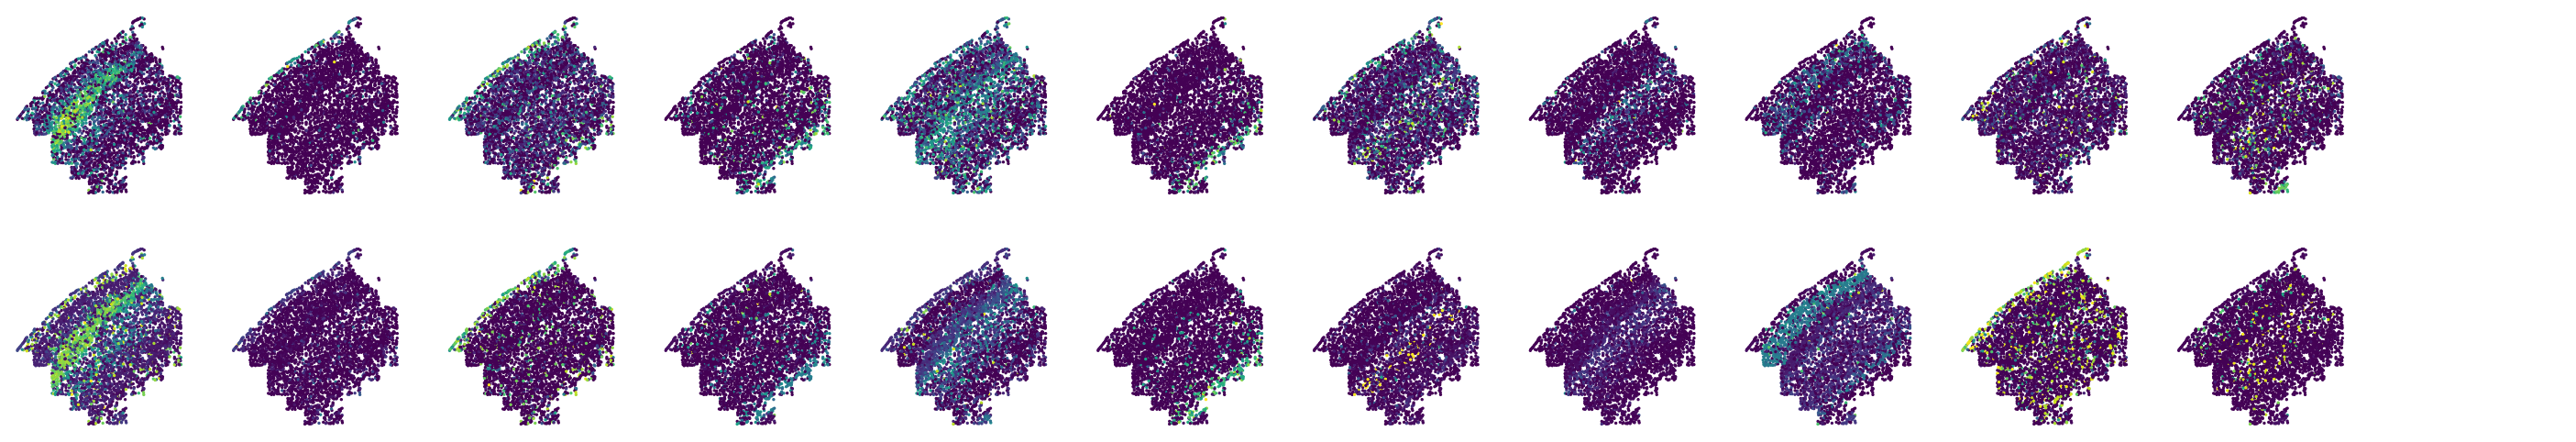

In [15]:
sdgelist = [fish_raw.to_df()[common_gene].T.values,
            pre_cluster[common_gene].T.values]
gene_names =fish_raw.to_df()[common_gene].columns
fish_loc_val = fish_loc[['X','Y']].values
genes = ['Rorb','Serpinf1','Aqp4','Prox1','Ptprm','Enpp6','Tshz2','Egln3','Egfem1','Ctss','Slc32a1','Eeln']
plt.figure(figsize=(36,6))
idx=1
for sdge in sdgelist:
    for gene in genes:       
        plt.subplot(len(sdgelist), len(genes), idx)
        plt.scatter(fish_loc_val[:,0], fish_loc_val[:,1], 
                            c=sdge[np.argwhere(gene_names == gene), :].flatten(),s=2, cmap='viridis')
        plt.axis('off')
        plt.gca().invert_yaxis()
        idx += 1
plt.savefig('mea_genel_cluster.png', dpi=600)
plt.show()